<img src="https://ww2.ufps.edu.co/public/archivos/elementos_corporativos/logoufps.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
HYBRID MODEL BASED ON ARTIFICIAL INTELLIGENCE FOR ENERGY DISPATCH IN A MICROGRID</font>  

<font size='4'> Forecast Regressor Wind Notebook</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 2023<br>
</font>

---

In [78]:
#Import libraries

import Utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['font.serif'] = ['Times New Roman']
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.utils import save_forecaster

In [79]:
#Load the dataset

datos = pd.read_csv('./3_Database.csv')
df = pd.DataFrame(datos)
df = df.drop(['index','Dia semana'],axis=1)

df.loc[df['Produccion FV (MW)'] < 0, 'Produccion FV (MW)'] = 0
df.loc[df['Produccion Eolica (MW)'] < 0, 'Produccion Eolica (MW)'] = 0
df.loc[df['Demanda (MW)'] < 0, 'Demanda (MW)'] = 0

reduccion = [0.2,0.2,0.06]

df['Produccion FV (MW)'] = df['Produccion FV (MW)']*reduccion[0]
df['Produccion Eolica (MW)'] = df['Produccion Eolica (MW)']*reduccion[1]
df['Demanda (MW)'] = df['Demanda (MW)']*reduccion[2]

In [80]:
#Adjust the index according to the time

df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d-T%H:%M')
df= df.set_index('Time')
df= df.asfreq('5min')
df= df.sort_index()

In [81]:
#Split data into train, validation and test

df = df.loc['2019-01-01 00:00': '2021-12-31 23:55']
fin_train = '2021-05-25 23:55'
fin_validacion = '2021-09-12 23:55'
data_train = df.loc[: fin_train, :]
data_val   = df.loc[fin_train:fin_validacion, :]
data_test  = df.loc[fin_validacion:, :]

print(f"Fechas train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)}- 80%)")
print(f"Fechas validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)}- 10%)")
print(f"Fechas test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)}- 10%)")

Fechas train      : 2019-01-01 00:00:00 --- 2021-05-25 23:55:00  (n=252288- 80%)
Fechas validation : 2021-05-25 23:55:00 --- 2021-09-12 23:55:00  (n=31681- 10%)
Fechas test       : 2021-09-12 23:55:00 --- 2021-12-31 23:55:00  (n=31681- 10%)


In [82]:
marker1 = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, alpha=1.00,label="Test", color="blue")
marker2 = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, alpha=1.00,label="Prediction", color="green")

<b> <font size='5'>SARIMA Model</font>

In [8]:
#Entrenamiento del Forecaster

from skforecast.model_selection_statsmodels import grid_search_sarimax
df = df.resample(rule='H').mean()

param_grid = {'order': [(4, 1, 0),(0, 1, 3)],
                'seasonal_order': [(2, 1, 0, 24),(1, 1, 1, 24)],
                'trend': [None, 'n', 'c']}

results_grid = grid_search_sarimax(
                    y = df['Produccion Eolica (MW)'],
                    param_grid = param_grid,
                    initial_train_size = len(df[:fin_validacion]),
                    fixed_train_size = False,
                    steps = 7,
                    metric = 'mean_absolute_error',
                    refit = False,
                    verbose = False,
                    fit_kwargs = {'maxiter': 200, 'disp': 0},
                    exog = df[['Estacion','Humedad','Velocidad']]
                )

results_grid

root       INFO  Number of models compared: 12
100%|██████████████████████████████████████████████████| 12/12 [1:38:25<00:00, 492.09s/it]


,params,metric,order,seasonal_order,trend
9,"{'order': (0, 1, 3), 'seasonal_order': (1, 1, ...",84.156092,"(0, 1, 3)","(1, 1, 1, 24)",None
10,"{'order': (0, 1, 3), 'seasonal_order': (1, 1, ...",84.156092,"(0, 1, 3)","(1, 1, 1, 24)",n
11,"{'order': (0, 1, 3), 'seasonal_order': (1, 1, ...",84.158348,"(0, 1, 3)","(1, 1, 1, 24)",c
3,"{'order': (4, 1, 0), 'seasonal_order': (1, 1, ...",84.188343,"(4, 1, 0)","(1, 1, 1, 24)",None
4,"{'order': (4, 1, 0), 'seasonal_order': (1, 1, ...",84.188343,"(4, 1, 0)","(1, 1, 1, 24)",n
5,"{'order': (4, 1, 0), 'seasonal_order': (1, 1, ...",87.629369,"(4, 1, 0)","(1, 1, 1, 24)",c
6,"{'order': (0, 1, 3), 'seasonal_order': (2, 1, ...",87.750613,"(0, 1, 3)","(2, 1, 0, 24)",None
7,"{'order': (0, 1, 3), 'seasonal_order': (2, 1, ...",87.750613,"(0, 1, 3)","(2, 1, 0, 24)",n
8,"{'order': (0, 1, 3), 'seasonal_order': (2, 1, ...",87.751173,"(0, 1, 3)","(2, 1, 0, 24)",c
0,"{'order': (4, 1, 0), 'seasonal_order': (2, 1, ...",87.985258,"(4, 1, 0)","(2, 1, 0, 24)",None


In [73]:
from skforecast.model_selection_statsmodels import backtesting_sarimax
df = df.resample(rule='H').mean()

metrica, predicciones_SARIMA = backtesting_sarimax(
                                        y = df['Produccion Eolica (MW)'],
                                        order = (0, 1, 3),
                                        seasonal_order = (1, 1, 1, 24),
                                        initial_train_size = len(df[:fin_validacion]),
                                        fixed_train_size = False,
                                        steps = 7,
                                        metric = 'mean_absolute_error',
                                        refit = False,
                                        verbose = True,
                                        fit_kwargs = {'maxiter': 250, 'disp': 0},
                                        exog = df[['Estacion','Humedad','Velocidad']]
                                )

Number of observations used for training: 23664
Number of observations used for backtesting: 2640
    Number of folds: 378
    Number of steps per fold: 7
    Last fold only includes 1 observations.


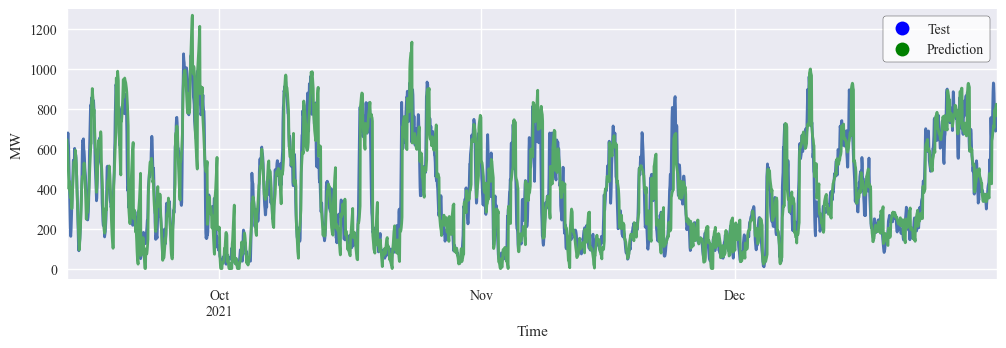

In [74]:
predicciones_SARIMA.loc[predicciones_SARIMA['predicted_mean'] < 0, 'predicted_mean'] = 0

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_SARIMA.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_SARIMA['predicted_mean'].plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(-50,1300)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Wind/SARIMA_Forecast.svg',bbox_inches='tight')

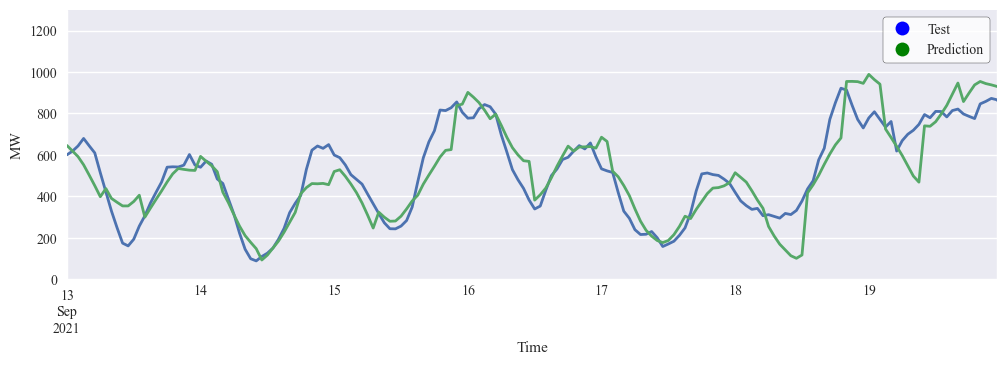

In [75]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_SARIMA.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_SARIMA['predicted_mean'].plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(0,1300)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Wind/SARIMA_Forecast_with_zoom.svg',bbox_inches='tight')

In [76]:
from sklearn.metrics import mean_squared_error
predicciones_SARIMA = predicciones_SARIMA.rename(columns={'predicted_mean':'pred'})
data_test = data_test.resample(rule='H').mean()

mape = Utils.calculate_mape(predicciones_SARIMA,data_test,'Produccion Eolica (MW)')
data_test = data_test.iloc[:len(data_test)-1]
rmse = np.sqrt(mean_squared_error(y_true=data_test['Produccion Eolica (MW)'],y_pred=predicciones_SARIMA['pred']))

print('Error backtest: ')
print(f'MAE SARIMA: {metrica} MW')
print(f'MAPE SARIMA: {mape} %')
print(f'RMSE SARIMA: {rmse}')


Error backtest: 
MAE SARIMA: 82.5336927723947 MW
MAPE SARIMA: 32.99674877103332 %
RMSE SARIMA: 103.46382875282447


<b> <font size='5'>Decision Tree Regressor Model</font>  

In [83]:
#Entrenamiento del Forecaster

from sklearn.tree import DecisionTreeRegressor

DT_forecaster = ForecasterAutoreg(
                regressor     = DecisionTreeRegressor(),
                lags          = 576,
                transformer_y = StandardScaler()
            )

DT_forecaster.fit(y=df.loc[:fin_validacion, 'Produccion Eolica (MW)'],exog = df[['Estacion','Humedad','Velocidad']][:fin_validacion])
DT_forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

In [84]:
#Backtesting del Forecaster

metrica, predicciones_DT = backtesting_forecaster(
                            forecaster = DT_forecaster,
                            y          = df['Produccion Eolica (MW)'],
                            initial_train_size = len(df.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 576,
                            metric     = ['mean_absolute_error','mean_squared_error'],
                            refit      = False,
                            verbose    = True,
                            exog = df[['Estacion','Humedad','Velocidad']]
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 283968
Number of observations used for backtesting: 31680
    Number of folds: 55
    Number of steps per fold: 576

Data partition in fold: 0
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-13 00:00:00 -- 2021-09-14 23:55:00  (n=576)
Data partition in fold: 1
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-15 00:00:00 -- 2021-09-16 23:55:00  (n=576)
Data partition in fold: 2
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-17 00:00:00 -- 2021-09-18 23:55:00  (n=576)
Data partition in fold: 3
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-19 00:00:00 -- 2021-09-20 23:55:00  (n=576)
Data partition in fold: 4
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Va

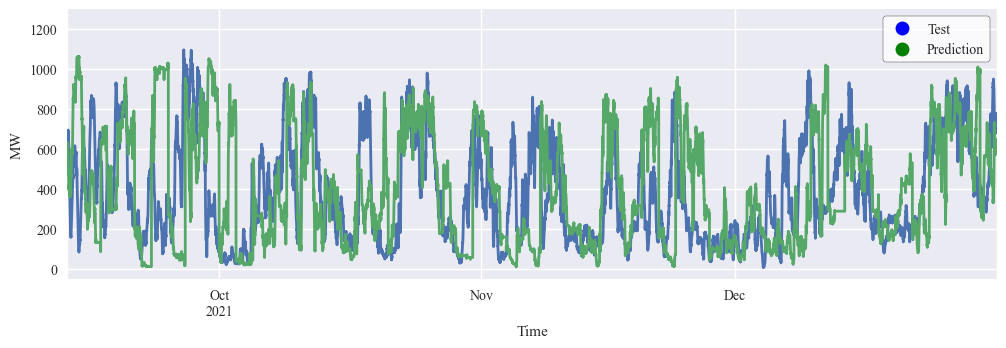

In [85]:
#Comparación de la predicción con respecto a los datos reales

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_DT.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_DT.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(-50,1300)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Wind/DT_Forecast_before.svg',bbox_inches='tight')

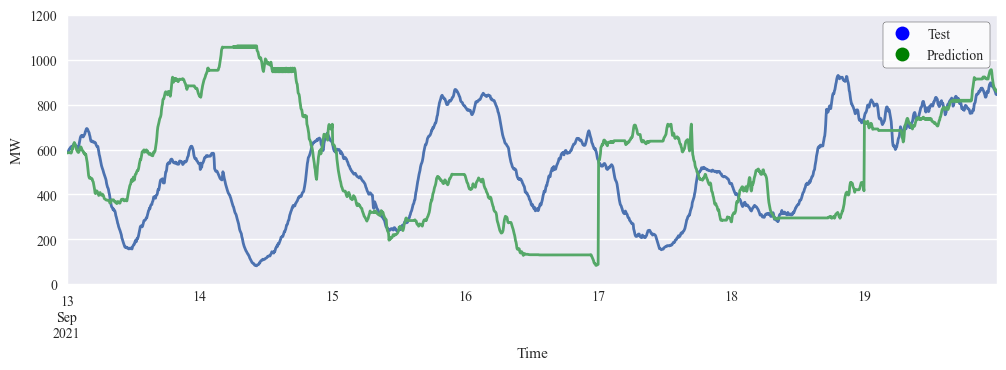

In [86]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_DT.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_DT.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(0,1200)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Wind/DT_Forecast_before_with_zoom.svg',bbox_inches='tight')

In [87]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_DT,data_test,'Produccion Eolica (MW)')
print('Error backtest: ')
print(f'MAE DT: {metrica[0]} MW')
print(f'MAPE DT: {mape} %')
print(f'RMSE DT: {np.sqrt(metrica[1])}')

Error backtest: 
MAE DT: 222.04565025252526 MW
MAPE DT: 99.54232868897701 %
RMSE DT: 303.97350761965424


In [88]:
#Hallando los hiperparámetros mediante tunning

DT_forecaster = ForecasterAutoreg(
                  regressor     = DecisionTreeRegressor(),
                  lags          = 576,
                  transformer_y = StandardScaler()# Este valor será remplazado en el grid search
            )

# Lags utilizados como predictores
lags_grid = [576]

# Hiperparámetros del regresor
param_grid = {
            'max_depth':[10,13],
            'min_samples_split':[10,30],
            'min_samples_leaf':[50,70],
            'max_features':[3,5]
            }

resultados_grid = grid_search_forecaster(
                        forecaster  = DT_forecaster,
                        y           = df.loc[:fin_validacion, 'Produccion Eolica (MW)'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 576,
                        metric      = ['mean_absolute_error','mean_squared_error'],
                        refit       = False,
                        initial_train_size = len(df[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False,
                        exog = df[['Estacion','Humedad','Velocidad']][:fin_validacion]
                  )

Number of models compared: 16.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [02:44<00:00, 164.80s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [89]:
resultados_grid

,lags,params,mean_absolute_error,mean_squared_error,max_depth,max_features,min_samples_leaf,min_samples_split
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 13, 'max_features': 5, 'min_samp...",183.830115,52510.541702,13,5,50,10
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 13, 'max_features': 3, 'min_samp...",187.760806,55294.015471,13,3,70,30
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 13, 'max_features': 3, 'min_samp...",187.994330,58311.291533,13,3,70,10
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 13, 'max_features': 3, 'min_samp...",188.870629,56483.099307,13,3,50,30
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 3, 'min_samp...",192.196456,59719.138246,10,3,70,10
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 3, 'min_samp...",197.232577,64868.936300,10,3,50,10
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 13, 'max_features': 5, 'min_samp...",197.428842,64305.150561,13,5,50,30
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 5, 'min_samp...",197.452721,61929.333473,10,5,50,10
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'max_features': 3, 'min_samp...",198.477218,65858.295557,10,3,50,30
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 13, 'max_features': 3, 'min_samp...",204.957181,67679.425900,13,3,50,10


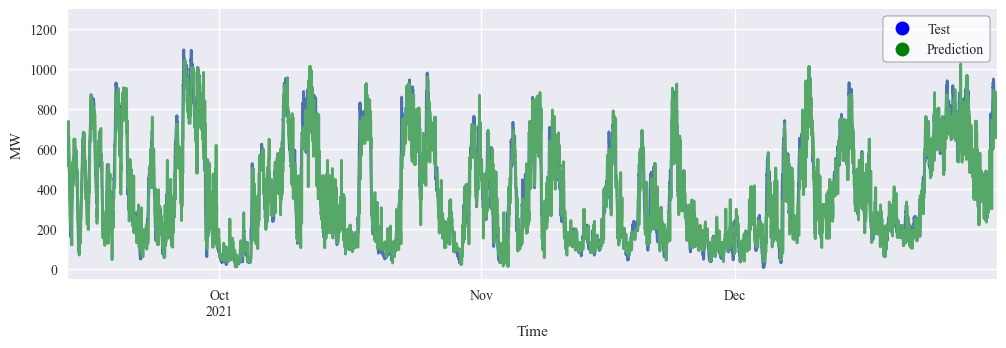

In [90]:
#Entrenamiento con nuevo modelo

metrica, predicciones_DT = backtesting_forecaster(
                            forecaster         = DT_forecaster,
                            y                  = df['Produccion Eolica (MW)'],
                            initial_train_size = len(df[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 1,
                            metric             = ['mean_absolute_error','mean_squared_error'],
                            refit              = False,
                            verbose            = False,
                            exog = df[['Estacion','Humedad','Velocidad']]
                        )

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_DT.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_DT.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(-50,1300)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Wind/DT_Forecast_after.svg',bbox_inches='tight')

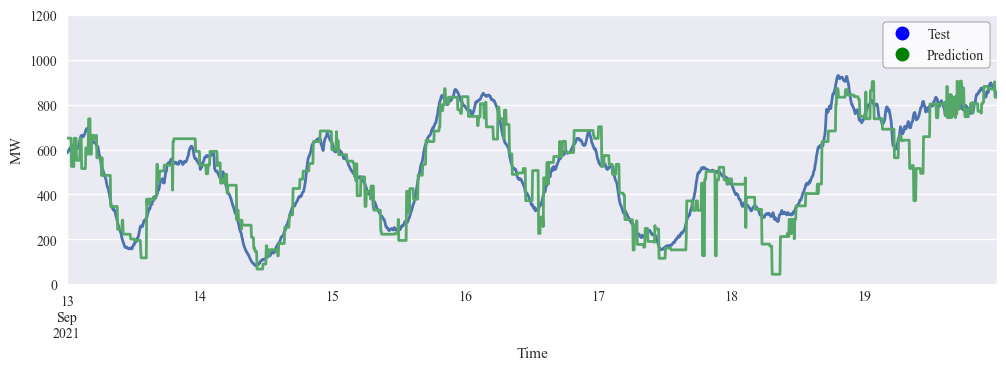

In [91]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_DT.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_DT.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(0,1200)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Wind/DT_Forecast_after_with_zoom.svg',bbox_inches='tight')

In [92]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_DT,data_test,'Produccion Eolica (MW)')
print('Error backtest: ')
print(f'MAE DT: {metrica[0]} MW')
print(f'MAPE DT: {mape} %')
print(f'RMSE DT: {np.sqrt(metrica[1])}')

Error backtest: 
MAE DT: 61.01447999983784 MW
MAPE DT: 24.649298390545333 %
RMSE DT: 85.57899314394837


In [93]:
#Save the model

save_forecaster(DT_forecaster, file_name='./Trained_models/DT_forecaster_Wind.py', verbose=False)

<b> <font size='5'>XGBoost Regressor Model</font>  

In [38]:
#Entrenamiento del Forecaster

from xgboost import XGBRegressor

XGB_forecaster = ForecasterAutoreg(
                regressor     = XGBRegressor(),
                lags          = 576,
                transformer_y = StandardScaler()
            )

XGB_forecaster.fit(y=df.loc[:fin_validacion, 'Produccion Eolica (MW)'],exog = df[['Estacion','Humedad','Velocidad']][:fin_validacion])
XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  5

In [39]:
#Backtesting del Forecaster

metrica, predicciones_XGB = backtesting_forecaster(
                            forecaster = XGB_forecaster,
                            y          = df['Produccion Eolica (MW)'],
                            initial_train_size = len(df.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 576,
                            metric     = ['mean_absolute_error','mean_squared_error'],
                            refit      = False,
                            verbose    = True,
                            exog = df[['Estacion','Humedad','Velocidad']]
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 283968
Number of observations used for backtesting: 31680
    Number of folds: 55
    Number of steps per fold: 576

Data partition in fold: 0
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-13 00:00:00 -- 2021-09-14 23:55:00  (n=576)
Data partition in fold: 1
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-15 00:00:00 -- 2021-09-16 23:55:00  (n=576)
Data partition in fold: 2
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-17 00:00:00 -- 2021-09-18 23:55:00  (n=576)
Data partition in fold: 3
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-19 00:00:00 -- 2021-09-20 23:55:00  (n=576)
Data partition in fold: 4
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Va

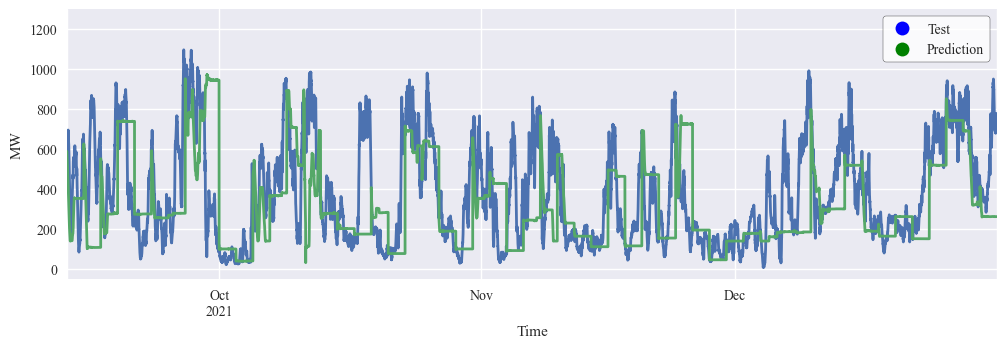

In [40]:
#Comparación de la predicción con respecto a los datos reales

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_XGB.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_XGB.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(-50,1300)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Wind/XGB_Forecast_before.svg',bbox_inches='tight')

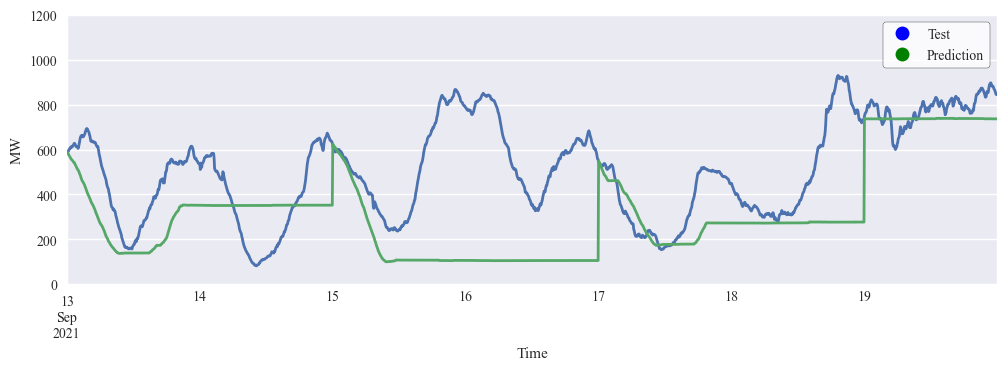

In [41]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_XGB.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_XGB.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(0,1200)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Wind/XGB_Forecast_before_with_zoom.svg',bbox_inches='tight')

In [42]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_XGB,data_test,'Produccion Eolica (MW)')
print('Error backtest: ')
print(f'MAE XGB: {metrica[0]} MW')
print(f'MAPE XGB: {mape} %')
print(f'RMSE XGB: {np.sqrt(metrica[1])}')

Error backtest: 
MAE XGB: 174.09805547738645 MW
MAPE XGB: 64.46280641549684 %
RMSE XGB: 249.16575314243576


In [43]:
#Hallando los hiperparámetros mediante tunning

XGB_forecaster = ForecasterAutoreg(
                    regressor     = XGBRegressor(),
                    lags          = 576,
                    transformer_y = StandardScaler()# Este valor será remplazado en el grid search
            )

# Lags utilizados como predictores
lags_grid = [576]

# Hiperparámetros del regresor
param_grid = {
            'learning_rate':[0.1,0.3],
            'n_estimators':[50,200],
            'max_depth':[3,5],
            }

resultados_grid = grid_search_forecaster(
                        forecaster  = XGB_forecaster,
                        y           = df.loc[:fin_validacion, 'Produccion Eolica (MW)'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 576,
                        metric      = ['mean_absolute_error','mean_squared_error'],
                        refit       = False,
                        initial_train_size = len(df[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False,
                        exog = df[['Estacion','Humedad','Velocidad']][:fin_validacion]
                    )

Number of models compared: 8.


loop lags_grid: 100%|█████████████████████████████████████| 1/1 [41:34<00:00, 2494.16s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [44]:
resultados_grid

,lags,params,mean_absolute_error,mean_squared_error,learning_rate,max_depth,n_estimators
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",182.705774,58434.996906,0.1,5.0,200.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",206.279557,66941.434203,0.1,5.0,50.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",224.881707,83696.133889,0.3,5.0,200.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",227.358211,84648.947193,0.3,5.0,50.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",233.529950,88528.205479,0.3,3.0,200.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",235.450151,91044.519455,0.1,3.0,200.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",236.273437,91611.369987,0.1,3.0,50.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",238.919396,94299.635251,0.3,3.0,50.0


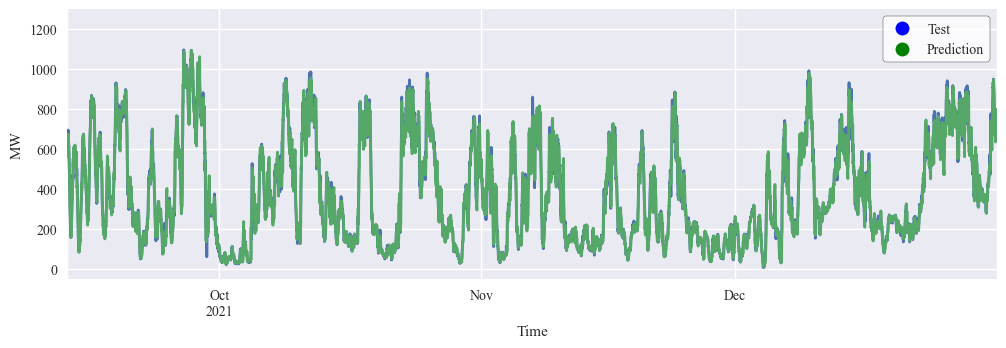

In [45]:
#Entrenamiento con nuevo modelo

metrica, predicciones_XGB = backtesting_forecaster(
                            forecaster         = XGB_forecaster,
                            y                  = df['Produccion Eolica (MW)'],
                            initial_train_size = len(df[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 12,
                            metric             = ['mean_absolute_error','mean_squared_error'],
                            refit              = False,
                            verbose            = False,
                            exog = df[['Estacion','Humedad','Velocidad']]
                        )

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_XGB.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_XGB.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(-50,1300)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Wind/XGB_Forecast_after.svg',bbox_inches='tight')

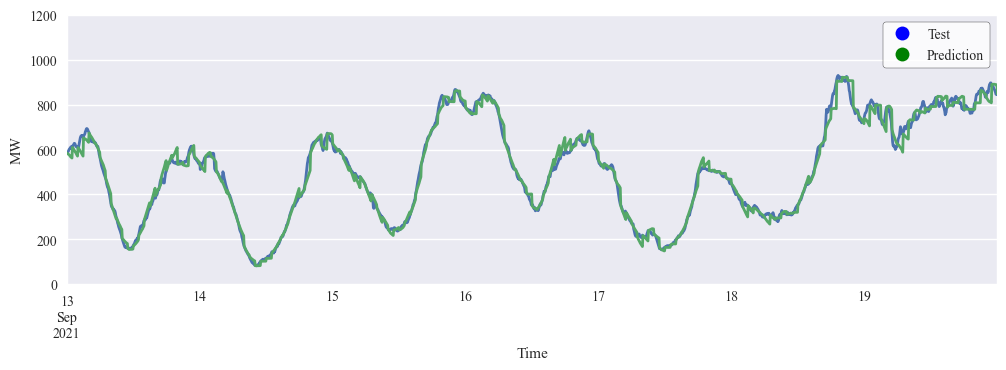

In [46]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_XGB.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_XGB.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(0,1200)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Wind/XGB_Forecast_after_with_zoom.svg',bbox_inches='tight')

In [47]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_XGB,data_test,'Produccion Eolica (MW)')
print('Error backtest: ')
print(f'MAE XGB: {metrica[0]} MW')
print(f'MAPE XGB: {mape} %')
print(f'RMSE XGB: {np.sqrt(metrica[1])}')

Error backtest: 
MAE XGB: 19.821816117511553 MW
MAPE XGB: 6.56279246790967 %
RMSE XGB: 31.347687927543337


In [48]:
#Save the model

save_forecaster(XGB_forecaster, file_name='./Trained_models/XGB_forecaster_Wind.py', verbose=False)

<b> <font size='5'>Multi Linear Regression Model</font>  

In [49]:
#Entrenamiento del Forecaster

from sklearn.linear_model import LinearRegression

LR_forecaster = ForecasterAutoreg(
                regressor     = LinearRegression(),
                lags          = 576,
                transformer_y = StandardScaler()
            )

LR_forecaster.fit(y=df.loc[:fin_validacion, 'Produccion Eolica (MW)'],exog = df[['Estacion','Humedad','Velocidad']][:fin_validacion])
LR_forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233

In [50]:
#Backtesting del Forecaster

metrica, predicciones_LR = backtesting_forecaster(
                            forecaster = LR_forecaster,
                            y          = df['Produccion Eolica (MW)'],
                            initial_train_size = len(df.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 576,
                            metric     = ['mean_absolute_error','mean_squared_error'],
                            refit      = False,
                            verbose    = True,
                            exog = df[['Estacion','Humedad','Velocidad']]
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 283968
Number of observations used for backtesting: 31680
    Number of folds: 55
    Number of steps per fold: 576

Data partition in fold: 0
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-13 00:00:00 -- 2021-09-14 23:55:00  (n=576)
Data partition in fold: 1
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-15 00:00:00 -- 2021-09-16 23:55:00  (n=576)
Data partition in fold: 2
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-17 00:00:00 -- 2021-09-18 23:55:00  (n=576)
Data partition in fold: 3
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Validation: 2021-09-19 00:00:00 -- 2021-09-20 23:55:00  (n=576)
Data partition in fold: 4
    Training:   2019-01-01 00:00:00 -- 2021-09-12 23:55:00  (n=283968)
    Va

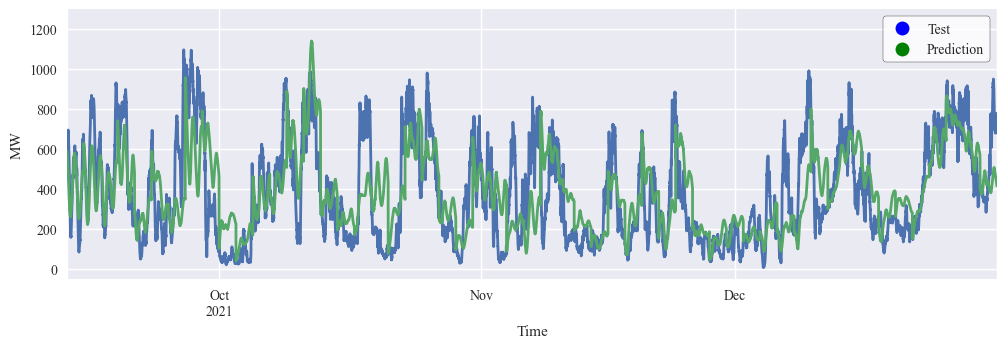

In [51]:
#Comparación de la predicción con respecto a los datos reales

predicciones_LR.loc[predicciones_LR['pred'] < 0, 'pred'] = 0
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_LR.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_LR.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(-50,1300)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Wind/LR_Forecast_before.svg',bbox_inches='tight')

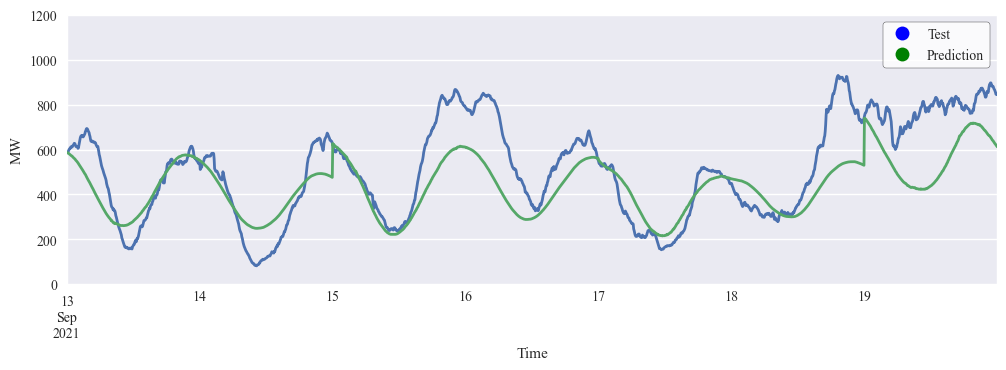

In [52]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_LR.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_LR.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(0,1200)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Wind/LR_Forecast_before_with_zoom.svg',bbox_inches='tight')

In [53]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_LR,data_test,'Produccion Eolica (MW)')
print('Error backtest: ')
print(f'MAE LR: {metrica[0]} MW')
print(f'MAPE LR: {mape} %')
print(f'RMSE LR: {np.sqrt(metrica[1])}')

Error backtest: 
MAE LR: 142.15441156442057 MW
MAPE LR: 70.05704182676244 %
RMSE LR: 187.29635765952335


In [54]:
#Hallando los hiperparámetros mediante tunning

LR_forecaster = ForecasterAutoreg(
                    regressor     = LinearRegression(),
                    lags          = 576,
                    transformer_y = StandardScaler()# Este valor será remplazado en el grid search
            )

# Lags utilizados como predictores
lags_grid = [576]

param_grid = {
            'fit_intercept':[True,False],
            'n_jobs':[None,-1]
            }

resultados_grid = grid_search_forecaster(
                        forecaster  = LR_forecaster,
                        y           = df.loc[:fin_validacion, 'Produccion Eolica (MW)'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 576,
                        metric      = ['mean_absolute_error','mean_squared_error'],
                        refit       = False,
                        initial_train_size = len(df[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False,
                        exog = df[['Estacion','Humedad','Velocidad']][:fin_validacion]
                    )

Number of models compared: 4.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [02:48<00:00, 168.08s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [55]:
resultados_grid

,lags,params,mean_absolute_error,mean_squared_error,fit_intercept,n_jobs
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'fit_intercept': True, 'n_jobs': None}",147.747818,36452.295313,True,NaN
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'fit_intercept': True, 'n_jobs': -1}",147.747818,36452.295313,True,-1.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'fit_intercept': False, 'n_jobs': None}",147.749378,34452.701671,False,NaN
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'fit_intercept': False, 'n_jobs': -1}",147.749378,34452.701671,False,-1.0


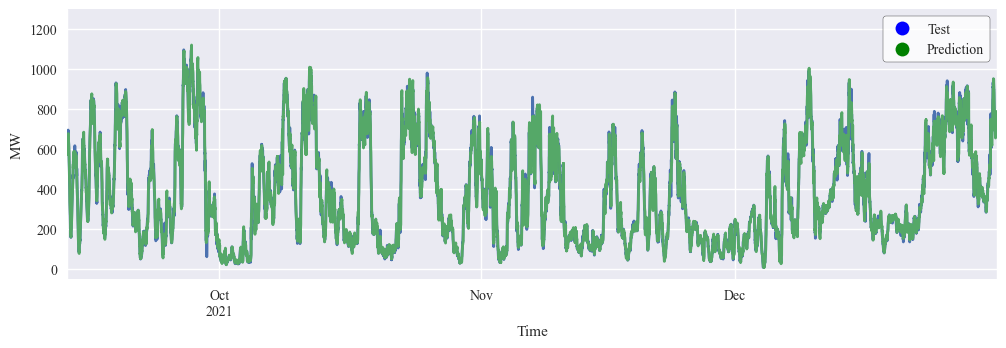

In [56]:
#Entrenamiento con nuevo modelo

metrica, predicciones_LR = backtesting_forecaster(
                            forecaster         = LR_forecaster,
                            y                  = df['Produccion Eolica (MW)'],
                            initial_train_size = len(df[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 12,
                            metric             = ['mean_absolute_error','mean_squared_error'],
                            refit              = False,
                            verbose            = False,
                            exog = df[['Estacion','Humedad','Velocidad']]
                        )

predicciones_LR.loc[predicciones_LR['pred'] < 0, 'pred'] = 0
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_LR.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_LR.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(-50,1300)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
plt.savefig('./Plots/Wind/LR_Forecast_after.svg',bbox_inches='tight')

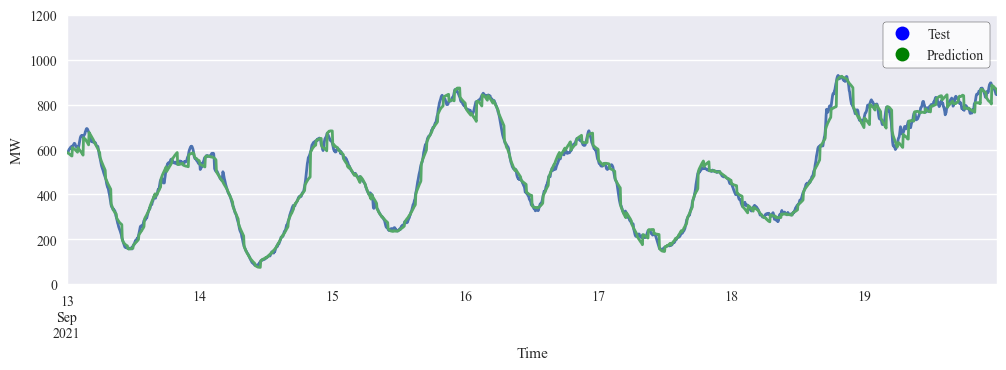

In [57]:
fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predicciones_LR.index, 'Produccion Eolica (MW)'].plot(ax=ax, linewidth=2, label='Test')
predicciones_LR.plot(linewidth=2, label='Predicción', ax=ax)
ax.set_ylim(0,1200)
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(handles=[marker1,marker2],frameon=True,edgecolor='black',facecolor='white')
ax.set_xlim('2021-09-13 00:00','2021-09-19 23:55')
plt.savefig('./Plots/Wind/LR_Forecast_after_with_zoom.svg',bbox_inches='tight')

In [58]:
#Análisis de las métricas

mape = Utils.calculate_mape(predicciones_LR,data_test,'Produccion Eolica (MW)')
print('Error backtest: ')
print(f'MAE LR: {metrica[0]} MW')
print(f'MAPE LR: {mape} %')
print(f'RMSE LR: {np.sqrt(metrica[1])}')

Error backtest: 
MAE LR: 19.355696122260756 MW
MAPE LR: 6.621762937629334 %
RMSE LR: 30.55291087811823


In [59]:
#Save the model

save_forecaster(LR_forecaster, file_name='./Trained_models/LR_forecaster_Wind.py', verbose=False)

<b> <font size='5'>Saving all the models</font>  

In [77]:
predicciones_SARIMA.to_csv('./Predictions/Wind/SARIMA_predictions.csv')
predicciones_DT.to_csv('./Predictions/Wind/DT_predictions.csv')
predicciones_XGB.to_csv('./Predictions/Wind/XGB_predictions.csv')
predicciones_LR.to_csv('./Predictions/Wind/LR_predictions.csv')